In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

### 設定圖形顯示大小

In [2]:
mpl.rcParams['font.family'] = 'Microsoft JhengHei'
plt.style.use('fivethirtyeight')

### 擷取資料

In [3]:
df = pd.read_csv('AEP_hourly.csv')
df = df.loc[df.Datetime >= '2005-01-01']
df["date"] = pd.to_datetime(df.pop("Datetime"), format="%Y-%m-%d %H:%M:%S")
df = df.sort_values(by='date')
df.head()

,AEP_MW,date
23,12892.0,2005-01-01 00:00:00
10941,12316.0,2005-01-01 01:00:00
10942,11890.0,2005-01-01 02:00:00
10943,11579.0,2005-01-01 03:00:00
10944,11461.0,2005-01-01 04:00:00


### 查看時間序列的特徵

#### 資料整體分布

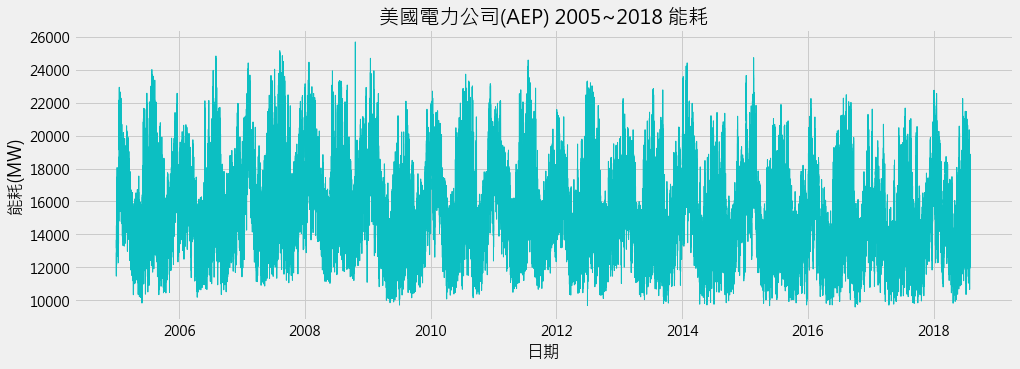

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.plot(df.date, df.AEP_MW, color='#0cbfc2', linewidth=1)
ax.title.set_text('美國電力公司(AEP) 2005~2018 能耗')
ax.set_xlabel('日期')
ax.set_ylabel('能耗(MW)')
ax.grid(True)

#### 查看時間序列相關特徵

In [5]:
df['year'] = df['date'].dt.year.astype('float64')
df['month'] = df['date'].dt.month.astype('float64')
df['dayofyear'] = df['date'].dt.dayofyear.astype('float64')
df['hour'] = df['date'].dt.hour.astype('float64')
df['quarter'] = df['date'].dt.quarter.astype('float64')
df.head()

,AEP_MW,date,year,month,dayofyear,hour,quarter
23,12892.0,2005-01-01 00:00:00,2005.0,1.0,1.0,0.0,1.0
10941,12316.0,2005-01-01 01:00:00,2005.0,1.0,1.0,1.0,1.0
10942,11890.0,2005-01-01 02:00:00,2005.0,1.0,1.0,2.0,1.0
10943,11579.0,2005-01-01 03:00:00,2005.0,1.0,1.0,3.0,1.0
10944,11461.0,2005-01-01 04:00:00,2005.0,1.0,1.0,4.0,1.0


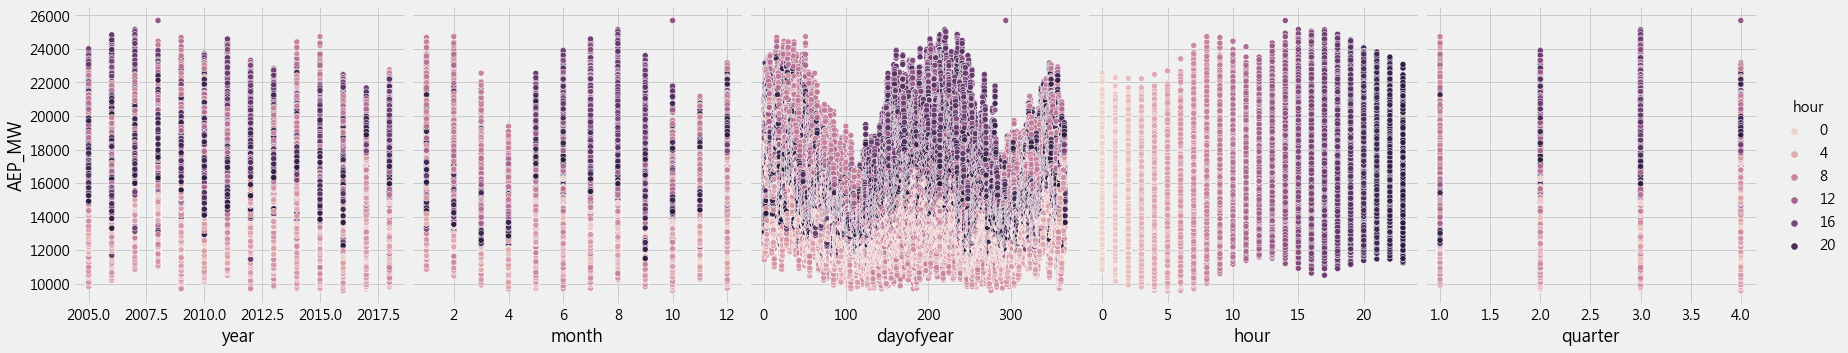

In [6]:
sns.pairplot(
    df,
    hue='hour',
    x_vars=['year','month','dayofyear','hour','quarter'],
    y_vars='AEP_MW',
    height=5,
)
plt.show()

### 前處理

#### 保留需要用到的特徵，並將耗電量往前shift一日當作Y

In [7]:
df = df[['date', 'AEP_MW']]

In [8]:
df['y'] = df['AEP_MW'].shift(-1)
df = df.dropna()
df.head()

,date,AEP_MW,y
23,2005-01-01 00:00:00,12892.0,12316.0
10941,2005-01-01 01:00:00,12316.0,11890.0
10942,2005-01-01 02:00:00,11890.0,11579.0
10943,2005-01-01 03:00:00,11579.0,11461.0
10944,2005-01-01 04:00:00,11461.0,11472.0


#### 2005~2012作為訓練集、2013~2015作為驗證集、2016~2018作為測試集

In [9]:
split_train_date = '2013-01-01'
split_valid_date = '2016-01-01'
train_data = df.loc[(df.date < split_train_date)].copy()
valid_data = df.loc[(df.date >= split_train_date) & (df.date < split_valid_date)].copy()
test_data = df.loc[df.date >= split_valid_date].copy()

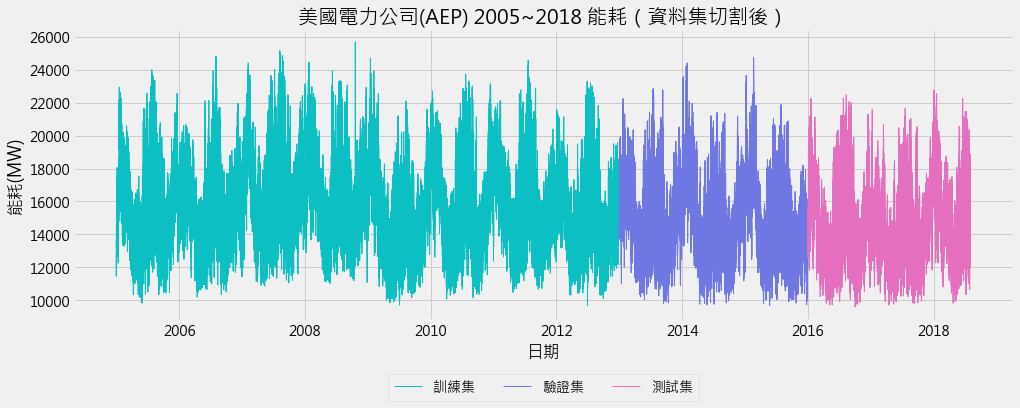

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.plot(train_data.date, train_data.AEP_MW, color='#0cbfc2', linewidth=1, label='訓練集')
plt.plot(valid_data.date, valid_data.AEP_MW, color='#6f77e3', linewidth=1, label='驗證集')
plt.plot(test_data.date, test_data.AEP_MW, color='#e36fbe', linewidth=1, label='測試集')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
ax.title.set_text('美國電力公司(AEP) 2005~2018 能耗（資料集切割後）')
ax.set_xlabel('日期')
ax.set_ylabel('能耗(MW)')
ax.grid(True)

#### Windowing

In [11]:
# Window sliding 切割函式，以過去24小時預測1小時
def data_split(input, reference=24, onlyX=False):
    sequence = input.copy()
    X, Y = [], []
    if onlyX:
        for i in range(reference, len(sequence)+1):
            X.append(np.array(sequence[i-reference: i]))
        return np.array(X)
    else:
        for i in range(reference, len(sequence)+1):
            X.append(np.array(sequence[i-reference: i, :-1]))
            Y.append(np.array(sequence[i-1, -1]))
        return np.array(X), np.array(Y)

In [12]:
# drop掉date欄位並轉成numpy array
train_data = train_data.drop('date', axis=1).to_numpy()
valid_data = valid_data.drop('date', axis=1).to_numpy()
test_data = test_data.drop('date', axis=1).to_numpy()

### 建立模型

In [13]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape = (24, 1)),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

#### 訓練資料

In [14]:
# 切割Window
train_X, train_Y = data_split(train_data)
valid_X, valid_Y = data_split(valid_data)

# 訓練
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
mcp_save = tf.keras.callbacks.ModelCheckpoint('.power.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto')
history = lstm_model.fit(train_X, train_Y, validation_data=(valid_X, valid_Y), epochs=50, batch_size=32, callbacks=[mcp_save, early_stop]) #50
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/50
2191/2191 [==============================] - 73s 32ms/step - loss: 22193204.0000 - val_loss: 2686716.5000
Epoch 2/50
2191/2191 [==============================] - 69s 32ms/step - loss: 6777525.0000 - val_loss: 9885192.0000
Epoch 3/50
2191/2191 [==============================] - 78s 35ms/step - loss: 5089628.0000 - val_loss: 3108673.2500
Epoch 4/50
2191/2191 [==============================] - 86s 39ms/step - loss: 2731608.2500 - val_loss: 2295111.0000
Epoch 5/50
2191/2191 [==============================] - 86s 39ms/step - loss: 2413284.2500 - val_loss: 2035598.7500
Epoch 6/50
2191/2191 [==============================] - 71s 32ms/step - loss: 2374906.0000 - val_loss: 2396860.7500
Epoch 7/50
2191/2191 [==============================] - 71s 33ms/step - loss: 2176288.7500 - val_loss: 1746578.2500
Epoch 8/50
2191/2191 [==============================] - 70s 32ms/step - loss: 1832032.5000 - val_loss: 1650454.2500
Epoch 9/50
2191/2191 [==============================] - 75s 34ms/step -

#### 驗證結果

In [20]:
model = tf.keras.models.load_model('.power.hdf5')
test_X, test_Y = data_split(test_data)
history = model.evaluate(test_X, test_Y, batch_size=32)

708/708 [==============================] - 7s 10ms/step - loss: 41332.5430


#### 檢查Loss趨勢

Text(0.5, 1.0, 'Training curve')

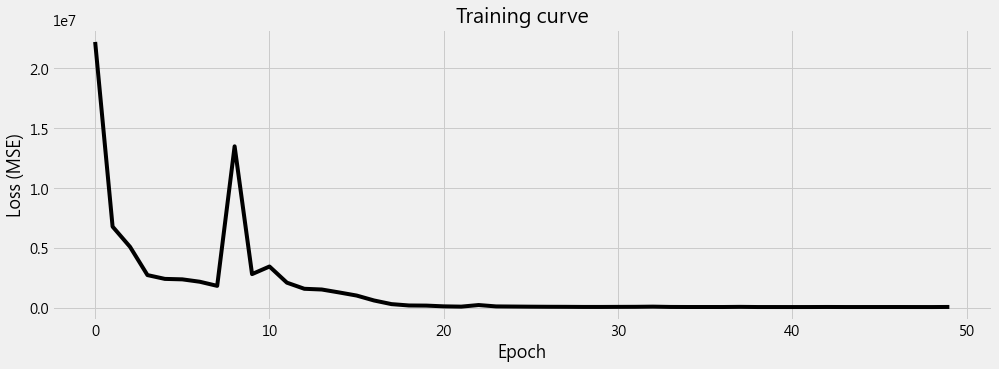

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.plot(epochs, loss, color='black')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.title('Training curve')

#### 預測未來值

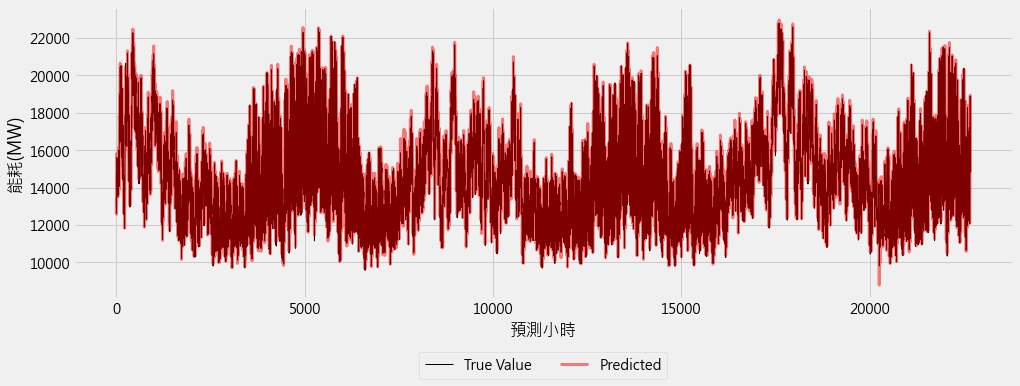

In [22]:
input = np.concatenate([valid_data[-24:], test_data])
input_X, input_Y = data_split(input)
predicted_Y = model.predict(input_X)
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.plot(input_Y, color='black', linewidth=1, label='True Value')
plt.plot(predicted_Y, color='red', alpha=0.5, linewidth=3, label='Predicted')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_xlabel('預測小時')
ax.set_ylabel('能耗(MW)')
ax.grid(True)

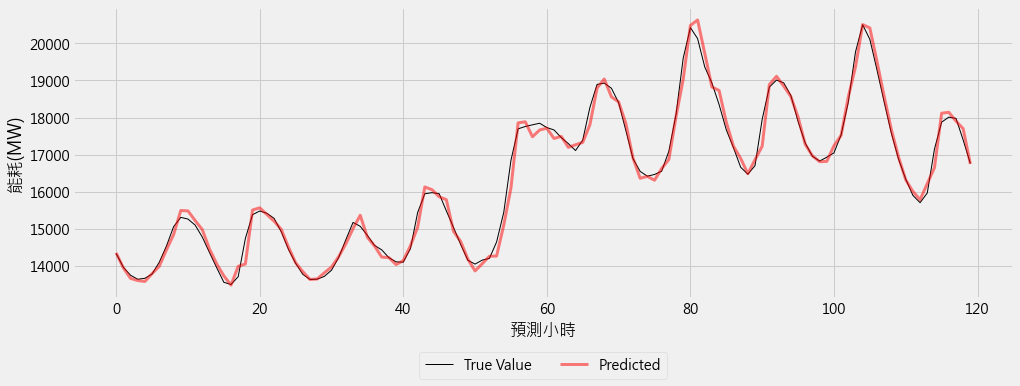

In [23]:
input = test_data[:143] # 143 - 24 + 1 = 120
input_X, input_Y = data_split(input)
predicted_Y = model.predict(input_X)
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.plot(input_Y, color='black', linewidth=1, label='True Value')
plt.plot(predicted_Y, color='red', alpha=0.5, linewidth=3, label='Predicted')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_xlabel('預測小時')
ax.set_ylabel('能耗(MW)')
ax.grid(True)

[14230. 13746. 13482. 13410. 13483. 13821. 14527. 15726. 16375. 16251.
 16049. 15750. 15399. 15195. 15116. 14735. 14566. 14821. 15729. 16262.
 16299. 16238. 15933. 15306.]


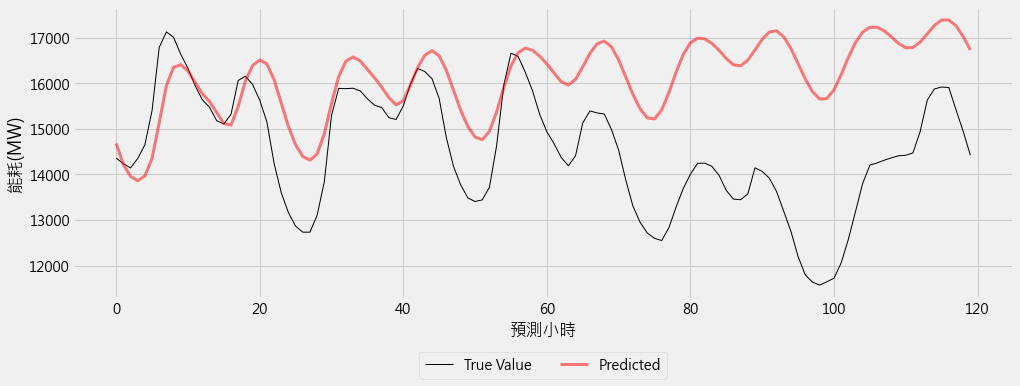

In [44]:
result = np.array([])
delay = 120
start_from_index = 16392
true_Y = test_data[start_from_index+24:start_from_index+24+delay, 1]
input = test_data[start_from_index:start_from_index+24, 0]
print(input)
input = input.reshape(input.shape[0],1)
for i in range(delay):
    input_X = data_split(input, onlyX=True)
    predicted_Y = model.predict(input_X)
    input = np.concatenate([input, predicted_Y])[-24:]
    result = np.append(result, predicted_Y)
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.plot(true_Y, color='black', linewidth=1, label='True Value')
plt.plot(result, color='red', alpha=0.5, linewidth=3, label='Predicted')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_xlabel('預測小時')
ax.set_ylabel('能耗(MW)')
ax.grid(True)